In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!pip install pyts
# Dataset (gunpoint...)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.6 MB/s eta 0:00:00


PTB dataset

In [ ]:

nRowsRead = 1000 # specify 'None' if want to read whole file
# ptbdb_abnormal.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('/kaggle/input/ptbdb_abnormal.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'ptbdb_abnormal.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

In [ ]:

print(ptbdb.shape)
ptbdb_abnormal.values[:,-1] # Abnormal is labelled one as per convention

In [ ]:

plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

Ford A,Ford B

In [ ]:
# FORD A data set (engine readings)

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [ ]:
x_train[0]

In [ ]:
x_train_temp=x_train[0:200]
y_train_temp=y_train[0:200]

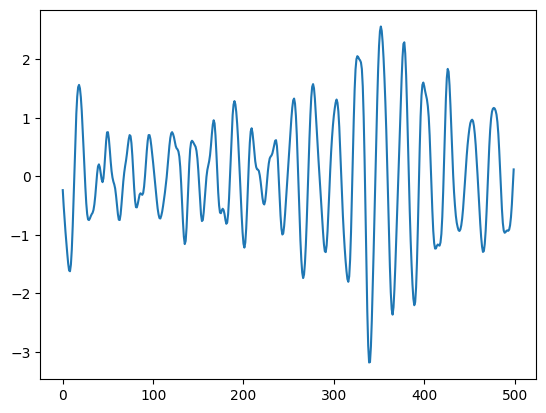

In [ ]:
plt.plot(x_train_temp[3])

plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
from pyts.image import GramianAngularField


In [ ]:
# gasf = GramianAngularField(method='summation')
# X_gasf = gasf.fit_transform(x_train)

In [ ]:

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(x_train_temp)


In [ ]:
# x_total_gaf=np.concatenate((X_gasf,X_gadf,np.zeros(X_gadf.shape)),axis=-1)

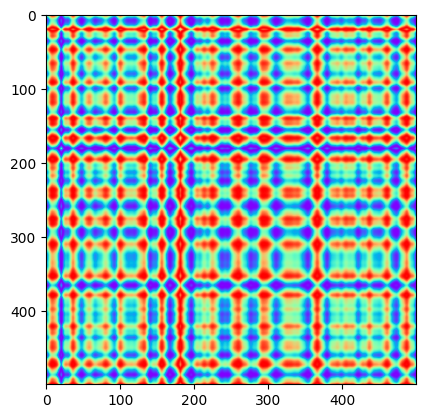

In [ ]:
plt.imshow(X_gadf[0], cmap='rainbow')
plt.imsave("logo.pdf",X_gadf[0], cmap='rainbow',format='pdf')

In [ ]:
plt.imsave('test.png',X_gadf[0], cmap='rainbow')

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [ ]:
#@title HELPER FUnctions
# Based on TF packages
import abc
import collections

import six

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import tensor_array_ops

_ButcherTableau = collections.namedtuple('_ButcherTableau', 'alpha beta c_sol c_mid c_error')

# Parameters from Shampine (1986), section 4.
_DORMAND_PRINCE_TABLEAU = _ButcherTableau(
    alpha=[1 / 5, 3 / 10, 4 / 5, 8 / 9, 1., 1.],
    beta=[
        [1 / 5],
        [3 / 40, 9 / 40],
        [44 / 45, -56 / 15, 32 / 9],
        [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729],
        [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656],
        [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84],
    ],
    c_sol=[35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0],
    c_mid=[
        6025192743 / 30085553152 / 2, 0, 51252292925 / 65400821598 / 2,
        -2691868925 / 45128329728 / 2, 187940372067 / 1594534317056 / 2,
        -1776094331 / 19743644256 / 2, 11237099 / 235043384 / 2
    ],
    c_error=[
        1951 / 21600 - 35 / 384,
        0,
        22642 / 50085 - 500 / 1113,
        451 / 720 - 125 / 192,
        -12231 / 42400 - -2187 / 6784,
        649 / 6300 - 11 / 84,
        1 / 60,
    ])


def _possibly_nonzero(x):
    return isinstance(x, ops.Tensor) or x != 0


def _scaled_dot_product(scale, xs, ys, name=None):
    """Calculate a scaled, vector inner product between lists of Tensors."""
    return math_ops.add_n(
        [(scale * x) * y for x, y in zip(xs, ys) if _possibly_nonzero(x) and _possibly_nonzero(y)], name='scaled_dot_product')


def _runge_kutta_step(func, y0, f0, t0, dt, tableau=_DORMAND_PRINCE_TABLEAU, name=None):
    """Take an arbitrary Runge-Kutta step and estimate error.
    Args:
        func                            : Function to evaluate like `func(y, t)` to compute the time derivative of `y`.
        y0 (Tensor)                     : Tensor initial value for the state.
        f0 (Tensor)                     : Tensor initial value for the derivative, computed from `func(y0, t0)`.
        t0 (float64)                    : Scalar Tensor giving the initial time.
        dt (float64)                    : Scalar Tensor giving the size of the desired time step.
        tableau (optional)              : _ButcherTableau describing how to take the Runge-Kutta step.
                                          Defaults to _DORMAND_PRINCE_TABLEAU.
        name (str, optional)            : Name for the operation. Defaults to None.
    Returns:
        `(y1, f1, y1_error, k)` (Tuple) : Gives the estimated function value after the Runge-Kutta step at
                                          `t1 = t0 + dt`, the derivative of the state at `t1`, estimated error at
                                          `t1`, and a list of Runge-Kutta coefficients `k` used
                                          for calculating these terms.
    """

    y0 = ops.convert_to_tensor(y0, name='y0')
    f0 = ops.convert_to_tensor(f0, name='f0')
    t0 = ops.convert_to_tensor(t0, name='t0')
    dt = ops.convert_to_tensor(dt, name='dt')
    dt_cast = math_ops.cast(dt, y0.dtype)

    k = [f0]
    for alpha_i, beta_i in zip(tableau.alpha, tableau.beta):
        ti = t0 + alpha_i * dt
        yi = y0 + _scaled_dot_product(dt_cast, beta_i, k)
        k.append(func(yi, ti))

    if not (tableau.c_sol[-1] == 0 and tableau.c_sol[:-1] == tableau.beta[-1]):
        yi = y0 + _scaled_dot_product(dt_cast, tableau.c_sol, k)

    y1 = array_ops.identity(yi, name='runge_kutta_step/y1')
    f1 = array_ops.identity(k[-1], name='runge_kutta_step/f1')
    y1_error = _scaled_dot_product(dt_cast, tableau.c_error, k, name='runge_kutta_step/y1_error')
    return (y1, f1, y1_error, k)


def _dot_product(xs, ys, name=None):
    """Calculate the vector inner product between two lists of Tensors."""
    return math_ops.add_n([x * y for x, y in zip(xs, ys)])


def _interp_fit(y0, y1, y_mid, f0, f1, dt):
    """Fit coefficients for 4th order polynomial interpolation.
    Args:
        y0 (Tensor)          : Function value at the start of the interval.
        y1 (Tensor)          : Function value at the end of the interval.
        y_mid (Tensor)       : Function value at the mid-point of the interval.
        f0 (Tensor)          : Derivative value at the start of the interval.
        f1 (Tensor)          : Derivative value at the end of the interval.
        dt (float64)         : Width of the interval.
    Returns:
        `[a, b, c, d, e]`    : For interpolating with the polynomial
                             `p = a * x ** 4 + b * x ** 3 + c * x ** 2 + d * x + e` for values of `x`
                             between 0 (start of interval) and 1 (end of interval).
    """

    a = _dot_product([-2 * dt, 2 * dt, -8, -8, 16], [f0, f1, y0, y1, y_mid])
    b = _dot_product([5 * dt, -3 * dt, 18, 14, -32], [f0, f1, y0, y1, y_mid])
    c = _dot_product([-4 * dt, dt, -11, -5, 16], [f0, f1, y0, y1, y_mid])
    d = dt * f0
    e = y0
    return [a, b, c, d, e]


def _interp_fit_rk(y0, y1, k, dt, tableau=_DORMAND_PRINCE_TABLEAU):
    """Fit an interpolating polynomial to the results of a Runge-Kutta step."""

    dt = math_ops.cast(dt, y0.dtype)
    y_mid = y0 + _scaled_dot_product(dt, tableau.c_mid, k)
    f0 = k[0]
    f1 = k[-1]
    return _interp_fit(y0, y1, y_mid, f0, f1, dt)


def _interp_evaluate(coefficients, t0, t1, t):
    """Evaluate polynomial interpolation at the given time point.
    Args:
        coefficients (Tensor)       : List of coefficients as created by `interp_fit`.
        t0 (float64)                : Scalar Tensor giving the start of the interval.
        t1 (float64)                : Scalar Tensor giving the end of the interval.
        t (float64)                 : Scalar Tensor giving the desired interpolation point.
    Returns:
        Polynomial interpolation of the coefficients at time `t`.
    """

    t0 = ops.convert_to_tensor(t0)
    t1 = ops.convert_to_tensor(t1)
    t = ops.convert_to_tensor(t)

    dtype = coefficients[0].dtype

    assert_op = control_flow_ops.Assert(
        (t0 <= t) & (t <= t1), ['invalid interpolation, fails `t0 <= t <= t1`:', t0, t, t1]
    )

    x = math_ops.cast((t - t0) / (t1 - t0), dtype)
    xs = [constant_op.constant(1, dtype), x]

    for _ in range(2, len(coefficients)):
        xs.append(xs[-1] * x)
    return _dot_product(coefficients, reversed(xs))


def _optimal_step_size(last_step, error_ratio, safety=0.9, ifactor=10.0, dfactor=0.2, order=5):
    """Calculate the optimal size for the next Runge-Kutta step."""

    error_ratio = math_ops.cast(error_ratio, last_step.dtype)
    exponent = math_ops.cast(1 / order, last_step.dtype)
    factor = math_ops.maximum(1 / ifactor, math_ops.minimum(error_ratio**exponent / safety, 1 / dfactor))
    return math_ops.divide(last_step, factor)


class _RungeKuttaState(collections.namedtuple('_RungeKuttaState', 'y1, f1, t0, t1, dt, interp_coeff')):
    """Saved state of the Runge Kutta solver."""


class _History(collections.namedtuple('_History', 'integrate_points, error_ratio')):
    """Saved integration history for use in `info_dict`."""


def _ta_append(tensor_array, value):
    """Append a value to the end of a tf.TensorArray."""
    return tensor_array.write(tensor_array.size(), value)


def _abs_square(x):
    if x.dtype.is_complex:
        return math_ops.square(math_ops.real(x)) + math_ops.square(math_ops.imag(x))
    else:
        return math_ops.square(x)


def _assert_increasing(t):
    assert_increasing = control_flow_ops.Assert(
        math_ops.reduce_all(t[1:] > t[:-1]), ['`t` must be monotonic increasing'])
    return ops.control_dependencies([assert_increasing])


def _check_input_sizes(t, dt):
    if len(t.get_shape().as_list()) > 1:
        raise ValueError('`t` must be a 1D tensor')

    if len(dt.get_shape().as_list()) > 1:
        raise ValueError('`dt` must be a 1D tensor')

    if t.get_shape()[0] != dt.get_shape()[0] + 1:
        raise ValueError('`t` and `dt` have incompatible lengths, must be N and N-1')


def _check_input_types(y0, t, dt=None):
    if not(y0.dtype.is_floating or y0.dtype.is_complex):
        raise TypeError('`y0` must have a floating point or complex floating point dtype')

    if not(t.dtype.is_floating):
        raise TypeError('`t` must have a floating point dtype')

    if dt is not None and not dt.dtype.is_floating:
        raise TypeError('`dt` must have a floating point dtype')


def _dopri5(func,
            y0,
            t,
            rtol,
            atol,
            full_output=False,
            first_step=None,
            safety=0.9,
            ifactor=10.0,
            dfactor=0.2,
            max_num_steps=1000,
            name=None):
    """Solve an ODE for `odeint` using method='dopri5'."""

    if first_step is None:
        first_step = 1.0

    first_step = ops.convert_to_tensor(first_step, dtype=t.dtype, name='first_step')
    safety = ops.convert_to_tensor(safety, dtype=t.dtype, name='safety')
    ifactor = ops.convert_to_tensor(ifactor, dtype=t.dtype, name='ifactor')
    dfactor = ops.convert_to_tensor(dfactor, dtype=t.dtype, name='dfactor')
    max_num_steps = ops.convert_to_tensor(max_num_steps, dtype=dtypes.int32, name='max_num_steps')

    def adaptive_runge_kutta_step(rk_state, history, n_steps):
        """Take an adaptive Runge-Kutta step to integrate the ODE."""

        y0, f0, _, t0, dt, interp_coeff = rk_state
        check_underflow = control_flow_ops.Assert(t0 + dt > t0, ['underflow in dt', dt])
        check_max_num_steps = control_flow_ops.Assert(n_steps < max_num_steps, ['max_num_steps exceeded'])
        check_numerics = control_flow_ops.Assert(math_ops.reduce_all(math_ops.is_finite(abs(y0))),
                                                                    ['non-finite values in state `y`', y0])

        y1, f1, y1_error, k = _runge_kutta_step(func, y0, f0, t0, dt)

        error_tol = atol + rtol * math_ops.maximum(abs(y0), abs(y1))
        tensor_error_ratio = _abs_square(y1_error) / _abs_square(error_tol)
        error_ratio = math_ops.sqrt(math_ops.reduce_mean(tensor_error_ratio))
        accept_step = error_ratio <= 1

        y_next = control_flow_ops.cond(accept_step, lambda: y1, lambda: y0)
        f_next = control_flow_ops.cond(accept_step, lambda: f1, lambda: f0)
        t_next = control_flow_ops.cond(accept_step, lambda: t0 + dt, lambda: t0)
        interp_coeff = control_flow_ops.cond(accept_step, lambda: _interp_fit_rk(y0, y1, k, dt), lambda: interp_coeff)
        dt_next = _optimal_step_size(dt, error_ratio, safety, ifactor, dfactor)
        rk_state = _RungeKuttaState(y_next, f_next, t0, t_next, dt_next, interp_coeff)

        history = _History(
            _ta_append(history.integrate_points, t0 + dt),
            _ta_append(history.error_ratio, error_ratio)
        )
        return rk_state, history, n_steps + 1

    def interpolate(solution, history, rk_state, i):
        """Interpolate through the next time point, integrating as necessary."""

        rk_state, history, _ = control_flow_ops.while_loop(
            lambda rk_state, *_: t[i] > rk_state.t1,
            adaptive_runge_kutta_step, (rk_state, history, 0)
        )
        y = _interp_evaluate(rk_state.interp_coeff, rk_state.t0, rk_state.t1, t[i])
        solution = solution.write(i, y)
        return solution, history, rk_state, i + 1

    with _assert_increasing(t):
        num_times = array_ops.size(t)

    solution = tensor_array_ops.TensorArray(y0.dtype, size=num_times).write(0, y0)
    history =_History(
        integrate_points=tensor_array_ops.TensorArray(t.dtype, size=0, dynamic_size=True),
        error_ratio=tensor_array_ops.TensorArray(rtol.dtype, size=0, dynamic_size=True)
    )

    rk_state = _RungeKuttaState(y0, func(y0, t[0]), t[0], t[0], first_step, interp_coeff=[y0] * 5)

    solution, history, _, _ = control_flow_ops.while_loop(
        lambda _a, _b, _c, i: i < num_times,
        interpolate,
        (solution, history, rk_state, 1)
    )

    y = solution.stack()
    y.set_shape(t.get_shape().concatenate(y0.get_shape()))
    if not full_output:
        return y
    else:
        integrate_points = history.integrate_points.stack()
        info_dict = {
          'num_func_evals': 6 * array_ops.size(integrate_points) + 1,
          'integrate_points': integrate_points,
          'error_ratio': history.error_ratio.stack()
      }
    return (y, info_dict)


def odeint(func, y0, t, rtol=1e-6, atol=1e-12, method=None, options=None, full_output=False, name=None):
    """Integrate a system of ordinary differential equations.
    Args:
        func ([type])                       : Function that maps a Tensor holding the state `y` and a scalar
                                              Tensor `t` into a Tensor of state derivatives with respect to time.
        y0 (N-D Tensor)                     : Giving starting value of `y` at time point `t[0]`.
                                              May have any floating point or complex dtype.
        t (1-D Tensor)                      : Holding a sequence of time points for which to solve for `y`.
                                              The initial time point should be the first element of this sequence,
                                              and each time must be larger than the previous time. May have any
                                              floating point dtype. If not provided as a Tensor,
                                              converted to a Tensor with float64 dtype.
        rtol (float64, optional)            : Tensor specifying an upper bound on relative error,
                                              per element of `y`. Defaults to 1e-6.
        atol (float64, optional)            : Tensor specifying an upper bound on absolute error,
                                              per element of `y`. Defaults to 1e-12.
        method (string, optional)           : Indicates the integration method to use. Currently,
                                              the only valid option is `'dopri5'`. Defaults to None.
        options (optional)                  : Dictionary of configuring options for the indicated integration method.
                                              Can only be provided if a `method` is explicitly set.
                                              For `'dopri5'`, valid options include:
                                                * first_step: an initial guess for the size of the first integration
                                                (current default: 1.0, but may later be changed to use heuristics based
                                                on the gradient).
                                                * safety: safety factor for adaptive step control, generally a constant
                                                in the range 0.8-1 (default: 0.9).
                                                * ifactor: maximum factor by which the adaptive step may be increased
                                                (default: 10.0).
                                                * dfactor: maximum factor by which the adpative step may be decreased
                                                (default: 0.2).
                                                * max_num_steps: integer maximum number of integrate steps between time
                                                points in `t` (default: 1000).
        full_output (bool, optional)        : If True, `odeint` returns a tuple `(y, info_dict)`
                                              describing the integration process. Defaults to False.
        name (str, optional)                : Optional name for this operation. Defaults to None.
    Returns:
        y ((N+1)-D tensor)                  : Where the first dimension corresponds to different time points.
                                              Contains the solved value of y for each desired time point in `t`,
                                              with the initial value `y0` being the first element
                                              along the first dimension.
        info_dict                           : only if `full_output == True`. A dict with the following values:
                                                * num_func_evals: integer Tensor counting the number of function
                                                evaluations.
                                                * integrate_points: 1D float64 Tensor with the upper bound of each
                                                integration time step.
                                                * error_ratio: 1D float Tensor with the estimated ratio of
                                                the integration error to the error tolerance at each integration
                                                step. An ratio greater than 1 corresponds to rejected steps.
    Raises:
        ValueError                          : if an invalid `method` is provided.
        TypeError                           : if `options` is supplied without `method`,
                                              or if `t` or `y0` has an invalid dtype.
    """

    if method is not None and method != 'dopri5':
        raise ValueError('invalid method: %r' % method)

    if options is None:
        options = {}
    elif method is None:
        raise ValueError('cannot supply `options` without specifying `method`')

    y0 = ops.convert_to_tensor(y0, name='y0')
    t = ops.convert_to_tensor(t, preferred_dtype=dtypes.float64, name='t')
    _check_input_types(y0, t)

    error_dtype = abs(y0).dtype
    rtol = ops.convert_to_tensor(rtol, dtype=error_dtype, name='rtol')
    atol = ops.convert_to_tensor(atol, dtype=error_dtype, name='atol')

    return _dopri5(func, y0, t, rtol=rtol, atol=atol, full_output=full_output, name='odeint', **options)


# flake8: noqa: F831
@six.add_metaclass(abc.ABCMeta)
class _FixedGridIntegrator(object):
    """Base class for fixed-grid ODE integrators."""

    def integrate(self, evol_func, y0, time_grid, dt_grid, steps_on_intervals):
        """Returns integrated values of differential equations on the `time grid`.
        Numerically integrates differential equation defined via time derivative evaluator `evol_func` using
        fixed time steps specified in dt_grid.
        Args:
            evol_func (callable)        : evaluates time derivative of y at a given time.
            y0 (float)                  : N-D Tensor holds initial values of the solution
            time_grid (float)           : 1-D Tensor holding the time points at which the solution will be recorded
            dt_grid (float)             : 1-D Tensor holds fixed time steps to be used on time_grid intervals.
                                          Must have one less element than that of the time_grid
            steps_on_intervals (int)    : 1-D Tensor, must have the same size as dt_grid. Specifies number of
                                          steps needed for every interval.
                                          Assumes steps_on_intervals*dt_grid == time_intervals
        Returns:
            (N+1)-D tensor, where the first dimension corresponds to different time points.
            Contains the solved value of y for each desired time point in `t`, with the initial value `y0` being the first element along the first dimension.
        """

        iteration_func = self._make_iteration_func(evol_func, dt_grid)
        integrate_interval = self._make_interval_integrator(iteration_func, steps_on_intervals)

        num_times = array_ops.size(time_grid)
        current_time = time_grid[0]
        solution_array = tensor_array_ops.TensorArray(y0.dtype, num_times)
        solution_array = solution_array.write(0, y0)

        solution_array, _, _, _ = control_flow_ops.while_loop(
            lambda _a, _b, _c, i: i < num_times,
            integrate_interval,
            (solution_array, y0, current_time, 1)
        )

        solution_array = solution_array.stack()
        solution_array.set_shape(time_grid.get_shape().concatenate(y0.get_shape()))
        return solution_array

    def _make_iteration_func(self, evol_func, dt_grid):
        """Returns a function that builds operations of a single time step."""

        def iteration_func(y, t, dt_step, interval_step):
            """Performs a single time step advance."""
            dt = dt_grid[interval_step - 1]
            dy = self._step_function(evol_func, t, dt, y)
            dy = math_ops.cast(dy, dtype=y.dtype)
            return y + dy, t + dt, dt_step + 1, interval_step
        return iteration_func

    def _make_interval_integrator(self, iteration_func, interval_sizes):
        """Returns a function that builds operations for interval integration."""

        def integrate_interval(solution_array, y, t, interval_num):
            """Integrates y with fixed time step on interval `interval_num`."""

            y, t, _, _ = control_flow_ops.while_loop(
                lambda _a, _b, j, interval_num: j < interval_sizes[interval_num - 1],
                iteration_func,
                (y, t, 0, interval_num)
            )

            return solution_array.write(interval_num, y), y, t, interval_num + 1
        return integrate_interval

    @abc.abstractmethod
    def _step_function(self, evol_func, t, dt, y):
        pass


class _MidpointFixedGridIntegrator(_FixedGridIntegrator):
    """Fixed grid integrator implementing midpoint method. We will be using the explicit midpoint method.
    The local error at each step of the midpoint method is of order O(h^3), giving a global error of  order O(h^2).
    Args:
        _FixedGridIntegrator: Base class for fixed-grid ODE integrators.
    """

    def _step_function(self, evol_func, t, dt, y):
        dt_cast = math_ops.cast(dt, y.dtype)
        # yn1 = yn + h * f((tn + h)/2, (yn + f(tn, yn) * h/2))
        return dt_cast * evol_func(y + evol_func(y, t) * dt_cast / 2, t + dt / 2)


class _RK4FixedGridIntegrator(_FixedGridIntegrator):
    """Fixed grid integrator implementing RK4 method.
    This scheme is the most widely known member of the Runge-Kutta family and called "the Runge–Kutta method".
    The RK4 method is a fourth-order method, meaning that the local truncation error is on the order of O(h^5),
    while the total accumulated error is on the order of O(h^{4}).
    Args:
        _FixedGridIntegrator: Base class for fixed-grid ODE integrators.
    """

    def _step_function(self, evol_func, t, dt, y):
        k1 = evol_func(y, t)
        half_step = t + dt / 2
        dt_cast = math_ops.cast(dt, y.dtype)

        k2 = evol_func(y + dt_cast * k1 / 2, half_step)
        k3 = evol_func(y + dt_cast * k2 / 2, half_step)
        k4 = evol_func(y + dt_cast * k3, t + dt)
        return math_ops.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)


def odeint_fixed(func, y0, t, dt=None, method='rk4', name=None):
    """ODE integration on a fixed grid (with no step size control).
        Useful in certain scenarios to avoid the overhead of adaptive step size
        control, e.g. when differentiation of the integration result is desired and/or
        the time grid is known a priori to be sufficient.
    Args:
        func (function)             : Function that maps a Tensor holding the state `y` and a scalar Tensor
                                      `t` into a Tensor of state derivatives with respect to time.
        y0 (float or complex)       : N-D Tensor giving starting value of `y` at time point `t[0]`.
        t (float)                   : 1-D Tensor holding a sequence of time points for which to solve for and each time
                                      must be larger than the previous time. May have any floating point dtype.
        dt (float, optional)        : 0-D or 1-D Tensor providing time step suggestion to be used on time
                                      integration intervals in `t`. 1-D Tensor should provide values
                                      for all intervals, must have 1 less element than that of `t`.
                                      If given a 0-D Tensor, the value is interpreted as time step suggestion
                                      same for all intervals. If passed None, then time step is set to be the
                                      t[1:] - t[:-1]. Defaults to None. The actual step size is obtained by
                                      insuring an integer number of steps per interval, potentially reducing the
                                      time step. Defaults to None.
        method (str, optional)      :  One of 'midpoint' or 'rk4'. Defaults to 'rk4'.
        name (str, optional)        :  Optional name for the resulting operation. Defaults to None.
    Returns:
        y (Tensor)                  : (N+1)-D tensor, where the first dimension corresponds to different
                                      time points. Contains the solved value of y for each desired time point in
                                      `t`, with the initial value `y0` being the first element along the first
                                      dimension.
    Raises:
        ValueError                  : Upon caller errors.
    """

    y0 = ops.convert_to_tensor(y0, name='y0')
    t = ops.convert_to_tensor(t, preferred_dtype=dtypes.float64, name='t')

    intervals = t[1:] - t[:-1]
    if dt is None:
        dt = intervals
    dt = ops.convert_to_tensor(dt, preferred_dtype=dtypes.float64, name='dt')

    steps_on_intervals = math_ops.ceil(intervals / dt)
    dt = intervals / steps_on_intervals
    steps_on_intervals = math_ops.cast(steps_on_intervals, dtype=dtypes.int32)

    _check_input_types(y0, t, dt)
    _check_input_sizes(t, dt)

    with _assert_increasing(t):
        if method == 'midpoint':
            return _MidpointFixedGridIntegrator().integrate(func, y0, t, dt, steps_on_intervals)
        elif method == 'rk4':
            return _RK4FixedGridIntegrator().integrate(func, y0, t, dt, steps_on_intervals)
        else:
            raise ValueError('method not supported: {!s}'.format(method))

In [ ]:
# CONVODE definition

import tensorflow as tf
import keras.backend as K
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Layer

def set_gpu_config(device = "0",fraction=0.25):
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = fraction
    config.gpu_options.visible_device_list = device
    K.set_session(tf.compat.v1.Session(config=config))


class ODEBlock(Layer):

    def __init__(self, filters, kernel_size, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        super(ODEBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv2d_w1 = self.add_weight("conv2d_w1", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_w2 = self.add_weight("conv2d_w2", self.kernel_size + (self.filters + 1, self.filters), initializer='glorot_uniform')
        self.conv2d_b1 = self.add_weight("conv2d_b1", (self.filters,), initializer='zero')
        self.conv2d_b2 = self.add_weight("conv2d_b2", (self.filters,), initializer='zero')
        super(ODEBlock, self).build(input_shape)

    def call(self, x):
        t = K.constant([0, 1], dtype="float32")
        return odeint(self.ode_func, x, t, rtol=1e-3, atol=1e-3)[1]

    def compute_output_shape(self, input_shape):
        return input_shape

    def ode_func(self, x, t):
        y = self.concat_t(x, t)
        y = K.conv2d(y, self.conv2d_w1, padding="same")
        y = K.bias_add(y, self.conv2d_b1)
        y = K.relu(y)

        y = self.concat_t(y, t)
        y = K.conv2d(y, self.conv2d_w2, padding="same")
        y = K.bias_add(y, self.conv2d_b2)
        y = K.relu(y)

        return y

    def concat_t(self, x, t):
        new_shape = tf.concat(
            [
                tf.shape(x)[:-1],
                tf.constant([1],dtype="int32",shape=(1,))
            ], axis=0)

        t = tf.ones(shape=new_shape) * tf.reshape(t, (1, 1, 1, 1))
        return tf.concat([x, t], axis=-1)


def build_model(input_shape, num_classes):
    x = Input(input_shape)
    y = Conv2D(32, (3, 3), activation='relu')(x)
    y = MaxPooling2D((2,2))(y)
    y = Conv2D(64, (3, 3), activation='relu')(y)
    y = MaxPooling2D((2,2))(y)
    y = ODEBlock(64, (3, 3))(y)
    y = Flatten()(y)
    y = Dense(num_classes, activation='softmax')(y)
    return Model(x,y)



In [ ]:
# import cifar10
# testing on cifar is for convode only not with GAF

In [ ]:
X_gadf[0].shape

(500, 500)

In [ ]:
# gadf = GramianAngularField(method='difference')
X_gadf_test = gadf.fit_transform(x_test)

In [ ]:

X_train=X_gadf
X_test=X_gadf_test


In [ ]:
# lol dont judge haha for funzies
y_testz=[]
for i in y_test:
  if i==1:
      y_testz.append('0')
  elif i==2:
      y_testz.append('1')
y_test=y_testz

In [ ]:
y_train=[]
for i in y_train_temp:
  if i==1:
      y_train.append('0')
  elif i==2:
      y_train.append('1')

In [ ]:
from keras.utils import np_utils
from tensorflow import keras

set_gpu_config("0",0.25)

batch_size = 8
num_classes = 2
epochs = 10
image_shape = (500,500, 1)



x_train = X_train.reshape((-1,) + image_shape)



y_train = keras.utils.to_categorical(y_train_temp, num_classes)

model = build_model(image_shape, num_classes)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.2)

# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/10
20/20 [==============================] - 34s 413ms/step - loss: 0.0342 - accuracy: 0.9812 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 7s 357ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 7s 371ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 7s 355ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 7s 359ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 7s 357ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 7s 374ms/step - loss: 0.0000e+00 - accuracy: 1.0000

In [ ]:
model.save('/content/model')

In [ ]:
dot_img_file = 'modeoDE.pdf'
tf.keras.utils.plot_model(model, to_file=dot_img_file)

In [ ]:
#pip install netron

In [ ]:
#!zip -r /content/file.zip /content/model


['  adding: content/model/ (stored 0%)',
 '  adding: content/model/assets/ (stored 0%)',
 '  adding: content/model/variables/ (stored 0%)',
 '  adding: content/model/variables/variables.data-00000-of-00001 (deflated 29%)',
 '  adding: content/model/variables/variables.index (deflated 64%)',
 '  adding: content/model/keras_metadata.pb (deflated 89%)',
 '  adding: content/model/saved_model.pb (deflated 89%)',
 '  adding: content/model/fingerprint.pb (stored 0%)']

In [ ]:
x_test = X_test.reshape((-1,) + image_shape)
y_test  = keras.utils.to_categorical(y_test, num_classes)


score = model.evaluate(x_test, y_test, batch_size = 8,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# final accuracy on FORD dataset

Test loss: 0.1797569990158081
Test accuracy: 0.9333333373069763
